In [1]:
import torch 
import torchvision
from src.dataset import ImageWoof
from src.model import CNN 
import glob 
import cv2 
import numpy as np
import matplotlib.pyplot as plt 
# from torch.utils.tensorboard import SummaryWriter

# EDA

In [2]:
# ? Arbitrarily choosing image size as 255 for now
IMG_SIZE = 255
ROOT_DIR = 'data'
BATCH_SIZE = 64

train_dataset = ImageWoof(
    ROOT_DIR, 
    IMG_SIZE,
    train=True,
)
test_dataset = ImageWoof(
    ROOT_DIR, 
    IMG_SIZE,
    train=False,
)


classes = [
    "Australian terrier", 
    "Border terrier",
    "Samoyed", 
    "Beagle", 
    "Shih-Tzu", 
    "English foxhound", 
    "Rhodesian ridgeback", 
    "Dingo", 
    "Golden retriever", 
    "Old English sheepdog"
]



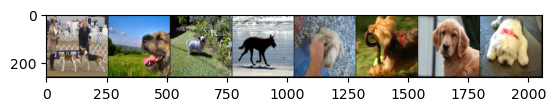

Beagle Shih-Tzu English foxhound Old English sheepdog Australian terrier English foxhound Rhodesian ridgeback Dingo


In [3]:
def show_samples(dataset, num_images):
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=num_images,
        shuffle=True, num_workers=2)
    
    dataiter = iter(loader)
    images, labels = next(dataiter)

    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(num_images)))


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


show_samples(train_dataset, 8)

In [4]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2
)

In [ ]:
# MAX_PARAMS = 3_000_000
# MAX_EPOCHS = 50
# LEARNING_RATE = 0.001
# net = CNN()
# assert net.num_of_params() <= MAX_PARAMS


In [ ]:
# from tqdm import tqdm, trange

# def train_one_epoch(
#     model: torch.nn.Module,
#     optimizer: torch.optim,
#     data_loader: torch.utils.data.DataLoader,
#     epoch_index: int,
#     criterion: torch.nn.CrossEntropyLoss,
#     device:str='cpu'  
# ):
#     with tqdm(data_loader, unit='batch') as data:
#         batch_loss_list = []
#         for batch in data:
#             data.set_description(f"Epoch {epoch_index}")

#             # ? Feeding to CNN
#             inputs, labels = batch[0].to(device), batch[1].to(device)
#             optimizer.zero_grad()

#             outputs = net(inputs)
            
#             # ? Getting Loss
#             batch_loss = criterion(outputs, labels)
#             batch_loss_list.append(batch_loss.item())
#             batch_loss.backward()

#             # ? Gradient Descent
#             optimizer.step()


#             data.set_postfix(
#                 batch_loss=batch_loss.item()
#             )

    
#     return {
#         'epoch_idx': epoch_index,
#         'batch_losses': batch_loss_list,
#         'epoch_loss': np.mean(batch_loss_list)
#     }



# def train(
#     model: torch.nn.Module,
#     optimizer: torch.optim,
#     data_loader: torch.utils.data.DataLoader,
#     epochs: int,
#     criterion: torch.nn.CrossEntropyLoss,
#     device:torch.device,
#     writer: SummaryWriter
# ):

    

#     model.train()

#     epoch_statistics_list = []
#     for epoch in range(epochs):
#         epoch_statistics = train_one_epoch(
#             model, optimizer, data_loader, epoch, criterion, device
#         )
        
#         epoch_statistics_list.append(epoch_statistics)
#         writer.add_scalar('Loss/train', epoch_statistics['epoch_loss'], epoch)



#     return epoch_statistics


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = CNN()
# model.to(device)
# optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9) 
# criterion = torch.nn.CrossEntropyLoss()
# writer = SummaryWriter()
# loss_statistics = train(model, optimizer, train_dataloader, MAX_EPOCHS, criterion, device, writer)
# writer.flush()




  0%|          | 0/142 [00:00<?, ?batch/s]/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <063DD42B-A1DA-3BBE-AD5E-03C12F7E3DBA> /opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ai701/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ai701/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your e

KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), 'model.pth')

In [ ]:
# batch_losses_0 = loss_statistics['batch_losses']
# np.mean(batch_losses_0), loss_statistics['epoch_loss']

(2.295109272003174, 5.092273697257042)

In [5]:
from tqdm import tqdm 
shapes = set()
errors = []
images = glob.glob('data/imagewoof2-160/*/*/*.JPEG')
print(len(images))

for img_path in tqdm(images):
    img = cv2.imread(img_path)
    try:
        shapes.add((img.shape))
    except AttributeError:
        errors.append(img_path)



# print(shapes)
heights_list = []
widths_list = []

for inst in shapes:
    h, w, _ = inst 
    heights_list.append(h)
    widths_list.append(w)

print(errors)


12954


  0%|          | 0/12954 [00:00<?, ?it/s]

100%|██████████| 12954/12954 [00:11<00:00, 1175.15it/s]

[]


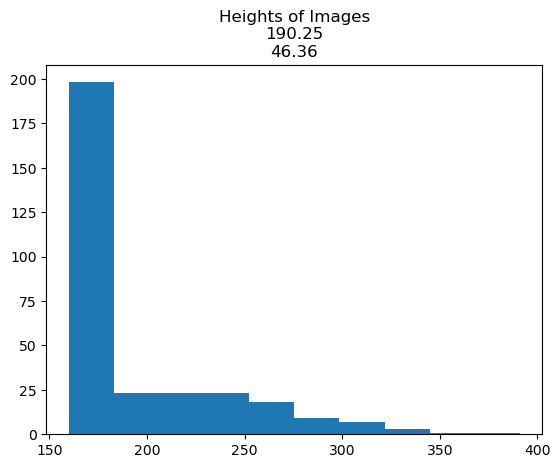

(array([160. , 183.1, 206.2, 229.3, 252.4, 275.5, 298.6, 321.7, 344.8,
        367.9, 391. ]),
 Counter({160: 175,
          183: 1,
          173: 1,
          196: 1,
          270: 1,
          260: 1,
          242: 1,
          232: 1,
          298: 1,
          255: 1,
          181: 1,
          204: 1,
          194: 1,
          176: 1,
          166: 1,
          341: 1,
          240: 1,
          179: 1,
          263: 1,
          253: 1,
          212: 1,
          268: 1,
          225: 1,
          174: 1,
          164: 1,
          187: 1,
          284: 1,
          177: 1,
          311: 1,
          350: 1,
          175: 1,
          239: 1,
          233: 1,
          246: 1,
          223: 1,
          236: 1,
          195: 1,
          234: 1,
          282: 1,
          305: 1,
          320: 1,
          231: 1,
          170: 1,
          254: 1,
          193: 1,
          391: 1,
          216: 1,
          222: 1,
          229: 1,
          188: 1,
   

In [6]:
from collections import Counter
plt.hist(heights_list)
mean_h, std_h = np.mean(heights_list), np.std(heights_list)
plt.title(f'Heights of Images\n{mean_h:.2f}\n{std_h:.2f}')
plt.xlabel('')
plt.show()

hist, bins = np.histogram(heights_list)
bins, Counter(heights_list)

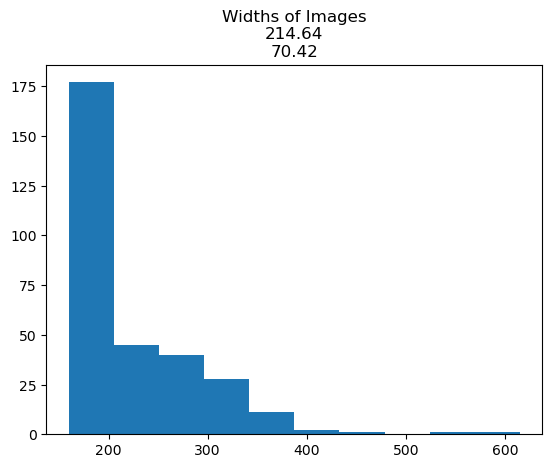

(array([160. , 205.5, 251. , 296.5, 342. , 387.5, 433. , 478.5, 524. ,
        569.5, 615. ]),
 Counter({160: 132,
          176: 1,
          231: 1,
          242: 1,
          286: 1,
          297: 1,
          352: 1,
          180: 1,
          191: 1,
          257: 1,
          246: 1,
          312: 1,
          365: 1,
          295: 1,
          193: 1,
          204: 1,
          248: 1,
          259: 1,
          314: 1,
          208: 1,
          329: 1,
          263: 1,
          274: 1,
          166: 1,
          210: 1,
          221: 1,
          287: 1,
          265: 1,
          342: 1,
          170: 1,
          236: 1,
          225: 1,
          291: 1,
          223: 1,
          183: 1,
          238: 1,
          172: 1,
          227: 1,
          359: 1,
          370: 1,
          187: 1,
          253: 1,
          308: 1,
          185: 1,
          240: 1,
          361: 1,
          200: 1,
          211: 1,
          189: 1,
          255: 1,
   

In [7]:
plt.hist(widths_list)
mean_w, std_w = np.mean(widths_list), np.std(widths_list)
plt.title(f'Widths of Images\n{mean_w:.2f}\n{std_w:.2f}')
plt.xlabel('')
plt.show()
hist, bins = np.histogram(widths_list)
bins, Counter(widths_list)

In [9]:
aspects = set()
for height, width in zip(heights_list, widths_list):
    aspect = width / height
    aspect = round(aspect, 2)
    aspects.add(aspect)


# sizes_list = list(zip(heights_list, widths_list))
sizes_counter = Counter(aspects)
sizes_counter

Counter({0.75: 1,
         1.1: 1,
         1.44: 1,
         1.51: 1,
         1.79: 1,
         1.86: 1,
         2.2: 1,
         2.28: 1,
         1.42: 1,
         2.24: 1,
         2.26: 1,
         1.5: 1,
         1.25: 1,
         0.5: 1,
         1.0: 1,
         0.84: 1,
         2.0: 1,
         1.93: 1,
         1.18: 1,
         1.68: 1,
         1.43: 1,
         1.75: 1,
         1.61: 1,
         1.36: 1,
         1.11: 1,
         0.54: 1,
         0.79: 1,
         1.54: 1,
         1.04: 1,
         1.29: 1,
         0.63: 1,
         0.88: 1,
         2.54: 1,
         2.29: 1,
         0.47: 1,
         0.72: 1,
         0.97: 1,
         1.72: 1,
         1.47: 1,
         1.22: 1,
         1.9: 1,
         1.65: 1,
         1.4: 1,
         1.15: 1,
         0.46: 1,
         0.41: 1,
         1.58: 1,
         1.83: 1,
         1.33: 1,
         1.08: 1,
         2.33: 1,
         2.08: 1,
         2.01: 1,
         0.51: 1,
         0.76: 1,
         1.26: 1,


In [8]:
round(5.34, 1)

5.3